# 1. Install libraries

In [ ]:
!pip install --quiet librosa scikit-learn statsmodels tqdm

In [ ]:
from google.colab import drive
import pathlib, os, librosa, numpy as np, pandas as pd, tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_auc_score, RocCurveDisplay
from statsmodels.stats.contingency_tables import mcnemar

# 2. Mount to drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# 3. Point to dataset

In [ ]:
root = pathlib.Path('/content/drive/MyDrive/Snoring Dataset/')

print('Snore files   :', len(list((root/'1').glob('*.wav'))))
print('Non‑snore files:', len(list((root/'0').glob('*.wav'))))

Snore files   : 501
Non‑snore files: 500


# 4. Extract 40‑D MFCC features  →  features.csv

In [ ]:
def mfcc40(path, n_mfcc=20):
    y, sr = librosa.load(path, sr=None)
    m = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.hstack([m.mean(axis=1), m.std(axis=1)])

records = []
for label in ('0', '1'):                                           # 0 = non‑snore, 1 = snore
    for wav in tqdm.tqdm((root/label).glob('*.wav')):
        records.append(np.hstack([mfcc40(wav), int(label)]))

df = pd.DataFrame(records, columns=[f'f{i}' for i in range(1,41)] + ['label'])
df.to_csv('features.csv', index=False)
print('Saved  features.csv   →', df.shape)

500it [00:34, 14.70it/s]
501it [00:16, 30.10it/s]


Saved  features.csv   → (1001, 41)


# 5. Set up 5-fold stratified CV

In [ ]:
X = df.iloc[:, :-1].values
y = df['label'].values
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 6. Define tuned classifiers (LogReg, kNN, SVM)

In [ ]:
def tuned(model, grid):
    return GridSearchCV(model, grid, cv=3, scoring='roc_auc', n_jobs=-1)

models = {
    'LogReg': tuned(LogisticRegression(max_iter=1000, solver='lbfgs'),
                    {'C': [0.01, 0.1, 1, 10]}),
    'kNN':    tuned(KNeighborsClassifier(),
                    {'n_neighbors': [1, 3, 5, 7, 11]}),
    'SVM':    tuned(SVC(kernel='rbf', probability=True),
                    {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']})
}

# 7. Run CV loop, collect confusion matrices & AUCs

In [ ]:
results = {}
for name, grid in models.items():
    cms, aucs = [], []
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
        pipe = make_pipeline(StandardScaler(), grid)
        pipe.fit(X[train_idx], y[train_idx])
        proba = pipe.predict_proba(X[test_idx])[:, 1]
        pred  = (proba >= 0.5).astype(int)
        cms.append(confusion_matrix(y[test_idx], pred))
        aucs.append(roc_auc_score(y[test_idx], proba))
        print(f'{name}  fold {fold}:  AUC = {aucs[-1]:.3f}')
    results[name] = {
        'conf': np.sum(cms, axis=0),
        'auc_mean': np.mean(aucs),
        'auc_se'  : np.std(aucs, ddof=1) / np.sqrt(len(aucs))
    }

LogReg  fold 1:  AUC = 0.973
LogReg  fold 2:  AUC = 0.986
LogReg  fold 3:  AUC = 0.995
LogReg  fold 4:  AUC = 0.976
LogReg  fold 5:  AUC = 0.987
kNN  fold 1:  AUC = 1.000
kNN  fold 2:  AUC = 1.000
kNN  fold 3:  AUC = 0.994
kNN  fold 4:  AUC = 0.992
kNN  fold 5:  AUC = 0.999
SVM  fold 1:  AUC = 1.000
SVM  fold 2:  AUC = 1.000
SVM  fold 3:  AUC = 1.000
SVM  fold 4:  AUC = 0.999
SVM  fold 5:  AUC = 1.000


# 8. Display summary table


In [ ]:
print('\n=== 5‑fold performance ===')
print('Model   Acc   Sens  Spec   AUC ± SE')
for name, r in results.items():
    tn, fp, fn, tp = r['conf'].ravel()
    acc  = (tp + tn) / (tp + tn + fp + fn)
    sens = tp / (tp + fn)
    spec = tn / (tn + fp)
    print(f'{name:6}  {acc:.3f}  {sens:.3f}  {spec:.3f}  {r["auc_mean"]:.3f} ± {r["auc_se"]:.3f}')


=== 5‑fold performance ===
Model   Acc   Sens  Spec   AUC ± SE
LogReg  0.934  0.932  0.936  0.983 ± 0.004
kNN     0.983  0.970  0.996  0.997 ± 0.002
SVM     0.996  0.994  0.998  1.000 ± 0.000


# 9. Plot ROC curve for the best model


Best model = SVM


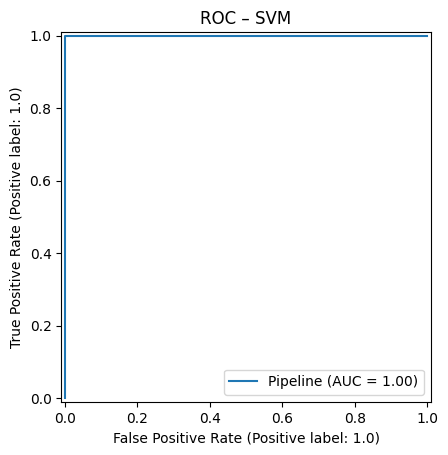

In [ ]:
best = max(results, key=lambda n: results[n]['auc_mean'])
print('\nBest model =', best)

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=1
)
best_pipe = make_pipeline(StandardScaler(), models[best].estimator)
best_pipe.fit(X_tr, y_tr)

RocCurveDisplay.from_estimator(best_pipe, X_te, y_te)
plt.title(f'ROC – {best}')
plt.show()

# 10. Mcnemar significance test (compare SVM vs LogReg)

In [ ]:
pred_svm = make_pipeline(StandardScaler(), models['SVM'].estimator).fit(X_tr, y_tr).predict(X_te)
pred_lr  = make_pipeline(StandardScaler(), models['LogReg'].estimator).fit(X_tr, y_tr).predict(X_te)

tbl = confusion_matrix(pred_svm, pred_lr)
print('\nDisagreement table\n', tbl)
print(mcnemar(tbl, exact=False))


Disagreement table
 [[49  1]
 [ 5 46]]
pvalue      0.22067136191984324
statistic   1.5
